In [36]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook

In [37]:
# Read in the basketball-reference dataframe
df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\df_with_all_positions_and_teams(2001-2024).csv")
df.set_index(['Season', 'Team', 'Player', 'Pos'], inplace=True)

In [38]:
# Cleaning up the dataframe
df.rename(columns = {'PF': 'Personal Fouls Committed'}, inplace=True)
df.rename(columns = {'Fouls Drawn - Shoot': 'Shooting Fouls Drawn'}, inplace=True)
df.drop(columns = ['% of FGA by Distance - 2P', 'FG'], inplace=True)

# Removing any players named "Player"
df.reset_index(inplace=True)
df = df[df['Player'] != 'Player']
df.set_index(['Season', 'Team', 'Player', 'Pos'], inplace=True)

# Changing all the values in the df to be floats so that I can apply PCA
df.fillna(0, inplace=True)  # Filling NaNs with 0
df = df.astype(float)

# Replacing any infinite values with 0
df.replace([np.inf, -np.inf], 0, inplace=True)

# Changing necessary stats to per 48 minutes
per_48_stats = ['FGA', 'Personal Fouls Committed', 'BLK', 'STL', 'DRB', 'ORB', 'TOV', 'AST']

for stat in per_48_stats:
    df[stat] = df[stat] / (df['MP'] / df['G']) * 48


# Reordering the columns
ordered_cols = ['G', 'MP', 'USG%', 'FGA', 'Personal Fouls Committed', 'BLK', 'STL', 'DRB', 'ORB', 'TOV', 'AST', "% of FG Ast'd - 3P", "% of FG Ast'd - 2P", 'FTr', 'Shooting Fouls Drawn', 'Corner 3s - %3PA', '% of FGA by Distance - 3P', '% of FGA by Distance - 16-3P', '% of FGA by Distance - 10-16', '% of FGA by Distance - 3-10', '% of FGA by Distance - 0-3', 'Dunks - %FGA', ]
df = df.reindex(columns = ordered_cols)

# Drop the Shooting Fouls column
df = df.drop(columns = 'Shooting Fouls Drawn')

# Dropping more unnecessary columns
df.drop(columns = ['Dunks - %FGA', 'Personal Fouls Committed'], inplace=True)
df['TRB'] = df['ORB'] + df['DRB']
df = df.drop(columns = ['ORB', 'DRB'])

In [39]:
# Creating a MPG column instead of the total minutes played
df['MPG'] = df['MP'] / df['G']
df = df.drop(columns = ['MP'])
df = df.reset_index()

In [40]:
df

,Season,Team,Player,Pos,G,USG%,FGA,BLK,STL,TOV,...,% of FG Ast'd - 2P,FTr,Corner 3s - %3PA,% of FGA by Distance - 3P,% of FGA by Distance - 16-3P,% of FGA by Distance - 10-16,% of FGA by Distance - 3-10,% of FGA by Distance - 0-3,TRB,MPG
0,2001,MIA,A.C. Green,PF,82.0,14.4,11.158044,0.278951,1.115804,1.394755,...,0.764,0.343,0.167,0.019,0.438,0.164,0.102,0.278,10.600142,17.207317
1,2001,CHI,A.J. Guyton,PG,33.0,16.5,14.582857,0.502857,0.754286,1.760000,...,0.608,0.094,0.275,0.359,0.427,0.094,0.042,0.078,2.765714,19.090909
2,2001,PHI,Aaron McKie,SG,76.0,18.9,14.323810,0.152381,2.133333,4.114286,...,0.481,0.272,0.359,0.238,0.209,0.183,0.137,0.232,6.247619,31.500000
3,2001,NJN,Aaron Williams,PF,82.0,17.8,13.310959,2.358904,1.179452,2.695890,...,0.623,0.477,0.000,0.003,0.103,0.131,0.262,0.502,12.131507,28.487805
4,2001,GSW,Adam Keefe,PF,67.0,11.5,9.232536,1.154067,1.538756,2.308134,...,0.683,0.396,0.333,0.019,0.258,0.170,0.176,0.377,11.925359,12.477612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13205,2024,CHI,Zach LaVine,SG,25.0,23.8,20.642202,0.412844,1.100917,2.889908,...,0.396,0.274,0.183,0.449,0.125,0.053,0.136,0.237,7.018349,34.880000
13206,2024,MEM,Zavier Simpson,PG,7.0,17.5,16.069565,0.834783,2.086957,2.921739,...,0.250,0.074,0.118,0.315,0.093,0.093,0.333,0.167,6.052174,23.000000
13207,2024,DEN,Zeke Nnaji,PF,58.0,15.4,12.566667,3.383333,1.450000,2.416667,...,0.619,0.416,0.391,0.154,0.007,0.027,0.215,0.597,10.633333,9.931034
13208,2024,MEM,Ziaire Williams,SF,51.0,19.7,17.452023,0.471676,1.650867,3.065896,...,0.641,0.198,0.370,0.500,0.069,0.085,0.127,0.220,8.254335,20.352941


In [41]:
# Defining lists for each season and team in the seasons
seasons = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
teams = df.reset_index()['Team'].unique().tolist()

In [42]:
# Creating a dictionary of individual rosters with proper weighting
roster_dfs = {}
for season in seasons:
    season_df = df[df['Season'] == season].copy()
    max_mp = season_df['MPG'].max()
    max_gp = season_df['G'].max()
    season_df['Player Weight'] = (0.7 * (season_df['MPG'] / max_mp)) + (0.3 * (season_df['G'] / max_gp))
    season_df = season_df.set_index(['Season', 'Team', 'Player', 'Pos', 'G', 'MPG'])
    for column in season_df.columns:
        if column != 'Player Weight':
            season_df[column] = season_df[column] * season_df['Player Weight']
    season_df = season_df.reset_index()
    for team in teams:
        if team in season_df['Team'].unique().tolist():
            team_df = season_df[season_df['Team'] == team].sort_values(by = 'Player Weight', ascending = False).head(9)
            team_df = team_df.set_index('Player')
            roster_dfs[str(season)+team] = team_df.drop(columns = ['Season', 'Team', 'Pos', 'G', 'MPG', 'Player Weight'])

In [43]:
aggregate_dfs = []
for roster in roster_dfs:
    aggregate_df = pd.DataFrame(roster_dfs[roster].mean()).T
    aggregate_df['Roster'] = roster
    aggregate_dfs.append(aggregate_df)
aggregates_df = pd.concat(aggregate_dfs, ignore_index=True).set_index('Roster')

In [44]:
aggregates_df

,USG%,FGA,BLK,STL,TOV,AST,% of FG Ast'd - 3P,% of FG Ast'd - 2P,FTr,Corner 3s - %3PA,% of FGA by Distance - 3P,% of FGA by Distance - 16-3P,% of FGA by Distance - 10-16,% of FGA by Distance - 3-10,% of FGA by Distance - 0-3,TRB
Roster,,,,,,,,,,,,,,,,
2001MIA,14.718647,11.119506,0.679186,1.113648,1.939690,2.911115,0.336181,0.406438,0.226507,0.094051,0.176192,0.161776,0.107894,0.108278,0.183090,5.983500
2001CHI,14.373478,11.385495,0.540390,1.208207,2.029441,3.366040,0.537979,0.435861,0.199752,0.195628,0.128284,0.178461,0.114477,0.094424,0.184744,5.110495
2001PHI,14.281575,11.065760,0.911429,1.192326,2.257909,2.994245,0.423150,0.406195,0.279576,0.122912,0.076487,0.117604,0.157956,0.167588,0.210909,6.877866
2001NJN,14.710140,11.891080,0.712652,1.185972,1.967071,2.679632,0.501012,0.414561,0.240679,0.119460,0.107388,0.168473,0.095731,0.102919,0.246872,5.798146
2001GSW,14.555899,12.653450,0.662977,1.211110,2.165906,3.132281,0.492624,0.377077,0.237184,0.097077,0.104155,0.161265,0.114217,0.160751,0.174698,7.029386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024MEM,16.017445,14.050917,0.711016,1.043312,2.243979,3.936655,0.583392,0.347840,0.176838,0.142844,0.333652,0.023634,0.045282,0.142604,0.147163,5.271173
2024OKC,14.843881,13.339354,0.953770,1.283633,1.702537,3.834423,0.628897,0.411209,0.154182,0.179041,0.295815,0.040103,0.074911,0.131444,0.188559,5.992650
2024BRK,14.749015,13.242605,0.694353,1.014782,1.786429,4.220275,0.635657,0.374552,0.159040,0.233627,0.335964,0.034923,0.064597,0.136117,0.173274,5.725334


In [45]:
# Normalizing the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(aggregates_df)
standardized_df = pd.DataFrame(standardized_data, columns=aggregates_df.columns, index=aggregates_df.index)

In [46]:
standardized_df

,USG%,FGA,BLK,STL,TOV,AST,% of FG Ast'd - 3P,% of FG Ast'd - 2P,FTr,Corner 3s - %3PA,% of FGA by Distance - 3P,% of FGA by Distance - 16-3P,% of FGA by Distance - 10-16,% of FGA by Distance - 3-10,% of FGA by Distance - 0-3,TRB
Roster,,,,,,,,,,,,,,,,
2001MIA,0.096432,-1.202856,-0.059867,0.150377,-0.271078,-0.965902,-2.313741,0.756652,0.645407,-1.753118,-0.282707,0.790132,1.373139,-0.233839,-0.891035,-0.196473
2001CHI,-0.416111,-0.917515,-1.041335,0.837987,0.207491,0.035361,0.171689,1.479019,-0.219071,0.629132,-0.967110,1.105428,1.680472,-0.759358,-0.841259,-1.919088
2001PHI,-0.552579,-1.260512,1.582384,0.722505,1.425724,-0.782936,-1.242594,0.750677,2.360112,-1.076251,-1.707077,-0.044630,3.710583,2.015966,-0.053776,1.568290
2001NJN,0.083800,-0.375147,0.176782,0.676298,-0.125077,-1.475380,-0.283616,0.956089,1.103317,-1.157213,-1.265631,0.916676,0.805193,-0.437116,1.028565,-0.562215
2001GSW,-0.145234,0.442687,-0.174489,0.859092,0.935145,-0.479128,-0.386920,0.035827,0.990404,-1.682146,-1.311826,0.780458,1.668350,1.756595,-1.143604,1.867269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024MEM,2.025026,1.941822,0.165211,-0.361083,1.351448,1.291250,0.731008,-0.681985,-0.959418,-0.608783,1.966751,-1.820423,-1.550301,1.068251,-1.972321,-1.602037
2024OKC,0.282392,1.178491,1.881786,1.386460,-1.535622,1.066244,1.291469,0.873783,-1.691454,0.240121,1.426207,-1.509194,-0.166898,0.644906,-0.726439,-0.178418
2024BRK,0.141526,1.074704,0.047383,-0.568547,-1.088294,1.915480,1.374719,-0.026179,-1.534500,1.520327,1.999776,-1.607087,-0.648454,0.822181,-1.186462,-0.705887


In [47]:
embedding = SpectralEmbedding(n_components=2, affinity='rbf')
transformed_data = embedding.fit_transform(standardized_df)

In [48]:
le_df = pd.DataFrame(transformed_data, index=standardized_df.index, columns = ['LE_Component_1', 'LE_Component_2']).reset_index()

In [49]:
records_df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\team_records_2001-2024.csv")

records_df['Rank-Statistic'] = records_df['Rank-Statistic'].str.replace('-', '')

records_df = records_df.set_index('Rank-Statistic')

records_df = records_df[~records_df['Overall'].isnull() & (records_df['Overall'] != 'Overall')]

records_df = records_df.copy()
records_df[['Wins', 'Losses']] = records_df['Overall'].str.split('-', expand=True)
records_df['Wins'] = records_df['Wins'].astype(int)
records_df['Losses'] = records_df['Losses'].astype(int)
records_df['Win_Percentage'] = records_df['Wins'] / (records_df['Wins'] + records_df['Losses'])

records_df = records_df.drop(columns = ['Overall', 'Wins', 'Losses'])

In [50]:
le_df = pd.merge(le_df, records_df.reset_index().rename(columns={'Rank-Statistic': 'Roster'}), on='Roster').set_index('Roster')

In [51]:
le_df

,LE_Component_1,LE_Component_2,Win_Percentage
Roster,,,
2001MIA,-0.003613,-0.000488,0.609756
2001CHI,-0.002703,0.000701,0.182927
2001PHI,-0.004050,-0.005367,0.682927
2001NJN,-0.003394,-0.002787,0.317073
2001GSW,-0.001157,-0.002348,0.207317
...,...,...,...
2024MIL,0.007169,0.000167,0.597561
2024MEM,0.007100,0.002961,0.329268
2024OKC,0.005757,0.000536,0.695122


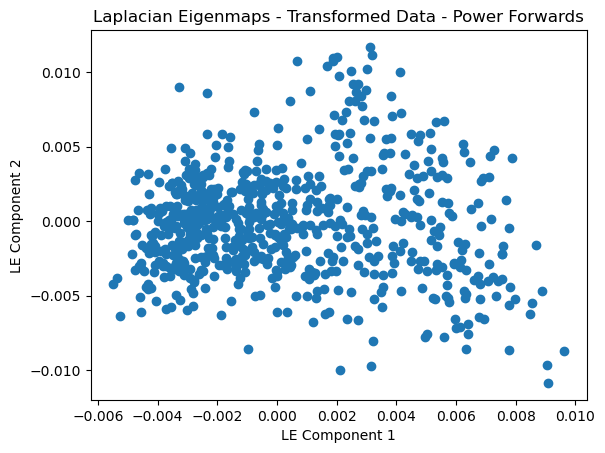

In [52]:
plt.scatter(le_df['LE_Component_1'], le_df['LE_Component_2'])
plt.title(f'Laplacian Eigenmaps - Transformed Data - Power Forwards')
plt.xlabel('LE Component 1')
plt.ylabel('LE Component 2')
plt.show()

In [53]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
from bokeh.models import ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.plotting import figure, show
from bokeh.models import Slider
from bokeh.layouts import column
from bokeh.io import show
from bokeh.models import Slider, CustomJS

In [59]:
# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_df)

# Creating padding for the bounds of the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.1
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.1

# Creating the figure for the bokeh plot
p = figure(
    title = 'Laplacian Eigenmaps for Aggregate Statistics Within a Roster',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save',
    x_range = (le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range = (le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='Win_Percentage', palette=Viridis256, low=le_df['Win_Percentage'].min(), high=le_df['Win_Percentage'].max())

# Creating the scatter plot
p.scatter(
    x = 'LE_Component_1',
    y = 'LE_Component_2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = mapper,
    legend_label = 'Aggregate Rosters'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster')
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='Win_Percentage')
p.add_layout(color_bar, 'right')

show(p)

In [55]:
le_df['Season'] = list(le_df.reset_index()['Roster'].apply(lambda roster: str(roster)[:4]))
le_df['Season'] = le_df['Season'].apply(lambda season: int(season))

In [56]:
le_df

,LE_Component_1,LE_Component_2,Win_Percentage,Season
Roster,,,,
2001MIA,-0.003613,-0.000488,0.609756,2001
2001CHI,-0.002703,0.000701,0.182927,2001
2001PHI,-0.004050,-0.005367,0.682927,2001
2001NJN,-0.003394,-0.002787,0.317073,2001
2001GSW,-0.001157,-0.002348,0.207317,2001
...,...,...,...,...
2024MIL,0.007169,0.000167,0.597561,2024
2024MEM,0.007100,0.002961,0.329268,2024
2024OKC,0.005757,0.000536,0.695122,2024


In [60]:
# Assuming 'Season' column exists in le_df and contains the season info
# Creating a ColumnDataSource for Bokeh with the full dataset
source = ColumnDataSource(le_df)

# Creating another ColumnDataSource for filtered data
filtered_source = ColumnDataSource(data=source.data)

# Creating padding for the bounds of the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.1
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.1

# Creating the figure for the bokeh plot
p = figure(
    title='Laplacian Eigenmaps for Aggregate Statistics Within a Roster',
    x_axis_label='Component 1',
    y_axis_label='Component 2',
    width=800,
    height=600,
    tools='pan, wheel_zoom, box_zoom, reset, save',
    x_range = (le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range = (le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the Win_Percentage values
mapper = linear_cmap(field_name='Win_Percentage', palette=Viridis256, low=le_df['Win_Percentage'].min(), high=le_df['Win_Percentage'].max())

# Creating the scatter plot
p.scatter(
    x='LE_Component_1',
    y='LE_Component_2',
    source=filtered_source,
    size=10,
    alpha=0.7,
    color=mapper,
    legend_label='Aggregate Rosters'
    
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster'),
    ('Season', '@Season'),
    ('Win_Percentage', '@Win_Percentage{0.00}')
]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0, 0), title='Win_Percentage')
p.add_layout(color_bar, 'right')

# Creating a slider for season filtering
slider = Slider(start=le_df['Season'].min(), end=le_df['Season'].max(), value=le_df['Season'].min(), step=1, title='Season')

# JavaScript callback to filter the data
callback = CustomJS(args=dict(source=source, filtered_source=filtered_source, slider=slider), code="""
    const season = slider.value;
    const data = source.data;
    const filtered_data = { LE_Component_1: [], LE_Component_2: [], Win_Percentage: [], Roster: [], Season: [] };

    for (let i = 0; i < data['Season'].length; i++) {
        if (data['Season'][i] === season) {
            filtered_data['LE_Component_1'].push(data['LE_Component_1'][i]);
            filtered_data['LE_Component_2'].push(data['LE_Component_2'][i]);
            filtered_data['Win_Percentage'].push(data['Win_Percentage'][i]);
            filtered_data['Roster'].push(data['Roster'][i]);
            filtered_data['Season'].push(data['Season'][i]);
        }
    }
    filtered_source.data = filtered_data;
    filtered_source.change.emit();
""")

slider.js_on_change('value', callback)

# Layout with the slider and the plot
layout = column(slider, p)

# Show the layout
show(layout)

In [61]:
# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_df)

# Creating padding for the bounds of the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.1
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.1

# Creating the figure for the bokeh plot
p = figure(
    title = 'Laplacian Eigenmaps for Aggregate Statistics Within a Roster',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save',
    x_range = (le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range = (le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='Season', palette=Viridis256, low=le_df['Season'].min(), high=le_df['Season'].max())

# Creating the scatter plot
p.scatter(
    x = 'LE_Component_1',
    y = 'LE_Component_2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = mapper,
    legend_label = 'Aggregate Rosters'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster')
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='Win_Percentage')
p.add_layout(color_bar, 'right')

show(p)